<a href="https://colab.research.google.com/github/clarakl/UoA-GEOG761/blob/main/761_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Cloud Clearing in Sentinel-2: combining spectral and clustering approaches

Our goal here is to prepare a Sentinel-2 image over a region of interest and create a cloud-clearing function that uses both:
- Spectral characteristics of clouds (e.g., high reflectance in blue, low in SWIR)
- A clustering algorithm (e.g., k-means or DBSCAN on pixel features) to find and expand cloud-masked areas to include neighboring “cloudy-ish” pixels.

My intent is that by the end of this lab you have a function that you can then use in many of your project workflows to ensure that the data you are using is as free of clouds as possible (you will need to re-design it if apply to imagery other than Sentinel 2).

The overview of our workflow is to:
- Load and filter Sentinel-2 surface reflectance imagery in Earth Engine.
- Apply the s2cloudless cloud probability algorithm.
- Apply a clustering approach to detect “borderline” cloudy pixels near heavy clouds.
- Generate a clean composite for a chosen date range.

We are using this tutorial from Google as the basis of our work: [Sentinel-2 Cloud Masking with s2cloudless](https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless).


**NOTE: in this lab whenever we ask you for an visual output, we are expecting you to present it to a publication quality level.**


________________________________________________________________________________
# Implementing S2 Cloudless

In [ ]:
# Our usual set up routine
# !pip install geemap --quiet

import geemap
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans

import ee
ee.Authenticate()
ee.Initialize(project='clara-geog761-tryout-1') #<- Remember to change this to your own project's name!

First, let us define our area of interest (AOI) and the cloud mask parameters: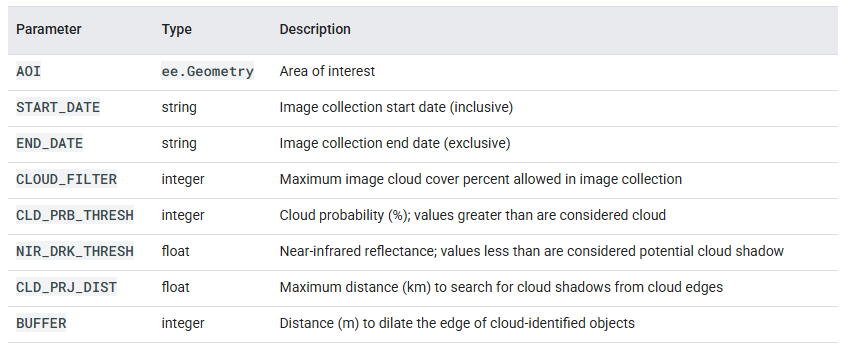

In [ ]:
# Control variables
AOI = ee.Geometry.Point(174.7633, -36.8485)
START_DATE = '2023-01-01'
END_DATE = '2023-03-31'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 30
NIR_DRK_THRESH = 0.1
CLD_PRJ_DIST_1 = 1.5
CLD_PRJ_DIST_2 = 2
BUFFER = 60

Next we use these variables to build a Sentinel 2 image collection. You have done all this before, but now we are using more of the tools at our disposal to get exactly what we want.

Also, from now on we are going to be using functions to make our code more useable and extensible:

In [ ]:
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

In [ ]:
# Apply the function in order to generate the collection
s2_sr_cld_col_eval = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

In [ ]:
# As ever, a good idea to do a quick viusalization check
Map = geemap.Map()
Map.centerObject(AOI, 10)
Map.addLayer(s2_sr_cld_col_eval, {'bands':['B4','B3','B2'], 'min':0, 'max':3000}, 'S2 collection (before)')
Map

Map(center=[-36.84850000000001, 174.7633], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

Yup that is pretty cloudy!

Now, we will define a function to add the s2cloudless probability layer and derived cloud mask as bands to an S2 SR image input.

In [ ]:
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

The next function we need adds bands that add dark pixels, cloud projection, and identified shadows as bands to an S2 SR image input. Note that the image input needs to be the result of the above add_cloud_bands function because it relies on knowing which pixels are considered cloudy (via the renamed 'CLD_PRB_THRESH' band native to this S2 product).

In [ ]:
def add_shadow_bands(img, shad_dist):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    # A classic characteristic of shadows is that the are very dark in the NIR band, here B8
    # By multiplying by not_water, pixels are only marked as potential shadows if they are
    # both dark in the NIR (which water is as well) and it is not water
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    # UTM projection: Universal Transverse Mercator projection (Different from the Mercator projection which distorts the sizes of specificlly Greenland and Africa).
    # -> a system for specifying locations on Earth using a grid-based coordinate system.
    # It divides the world into 60 zones, each 6 degrees of longitude wide,
    # and uses a Transverse Mercator projection within each zone to minimize distortion.
    # It takes the information from the image's metadata
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, shad_dist*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

Finally for this stage, we define a function to assemble all of the cloud and cloud shadow components and produce the final mask.

In [ ]:
def add_cld_shdw_mask(img, shad_dist):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud, shad_dist)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches (focalMin(2) removes single dark pixels that make no sense either way) and dilate remaining pixels by BUFFER input (focalMax() to make edges of clouds fuzzier).
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    # This two-step process of erosion then dilation is a standard image processing technique called "morphological opening," which is excellent for noise removal.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

Let us check this out and see how well it is dealing with our famously cloudy country. To do this we will need a function to pull out the cloud masking component layers, as in the 'final' version we will just apply this layer to remove the clouds rather than hold it as something we will display.

In [ ]:
def display_cloud_layers_geemap(col, AOI):
    # Mosaic the image collection.
    img = col.mosaic()

    # Subset layers and prepare them for display.
    clouds = img.select('clouds').selfMask()
    shadows = img.select('shadows').selfMask()
    dark_pixels = img.select('dark_pixels').selfMask()
    probability = img.select('probability')
    cloudmask = img.select('cloudmask').selfMask()
    cloud_transform = img.select('cloud_transform')

    # Create a geemap Map object centered on AOI.
    m = geemap.Map()
    m.centerObject(AOI, 12)

    # Add layers
    m.addLayer(img, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1}, 'S2 image')
    m.addLayer(probability, {'min': 0, 'max': 100}, 'probability (cloud)')
    m.addLayer(clouds, {'palette': ['e056fd']}, 'clouds')
    m.addLayer(cloud_transform, {'min': 0, 'max': 1, 'palette': ['white', 'black']}, 'cloud_transform')
    m.addLayer(dark_pixels, {'palette': ['orange']}, 'dark_pixels')
    m.addLayer(shadows, {'palette': ['yellow']}, 'shadows')
    m.addLayer(cloudmask, {'palette': ['orange']}, 'cloudmask')

    return m

In [ ]:
s2_sr_cld_col_eval_disp_1 = s2_sr_cld_col_eval.map(lambda img: add_cld_shdw_mask(img, CLD_PRJ_DIST_1))
display_map = display_cloud_layers_geemap(s2_sr_cld_col_eval_disp_1, AOI)
display_map

Map(center=[-36.84850000000001, 174.7633], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

In [ ]:
s2_sr_cld_col_eval_disp_2 = s2_sr_cld_col_eval.map(lambda img: add_cld_shdw_mask(img, CLD_PRJ_DIST_2))
display_map = display_cloud_layers_geemap(s2_sr_cld_col_eval_disp_2, AOI)
display_map

Map(center=[-36.84850000000001, 174.7633], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

Well now! That is considerably better than what we have been using before!

(1) Zoom in to a cloudy region and look at the S2 image, 'clouds' layer, 'dark pixels',  and the 'shadows' layers. Write a short paragraph that discusses:
- The performance of each masking element. Are they perfect or getting confused? What is causing the confusion?
- How do the three elements work together to define pixels that are not clear?
I am looking for you to show an understanding of both the algorithim you have just applied and the underlying spectral sensing principles.

(10 pts)

Fetching image collection from GEE...
Running analysis with initial parameters...
Running analysis with final parameters...
Generating image thumbnails from GEE... (This may take a moment)
Creating final figure...
Figure saved successfully as 'comparison_figure_3x2.png'


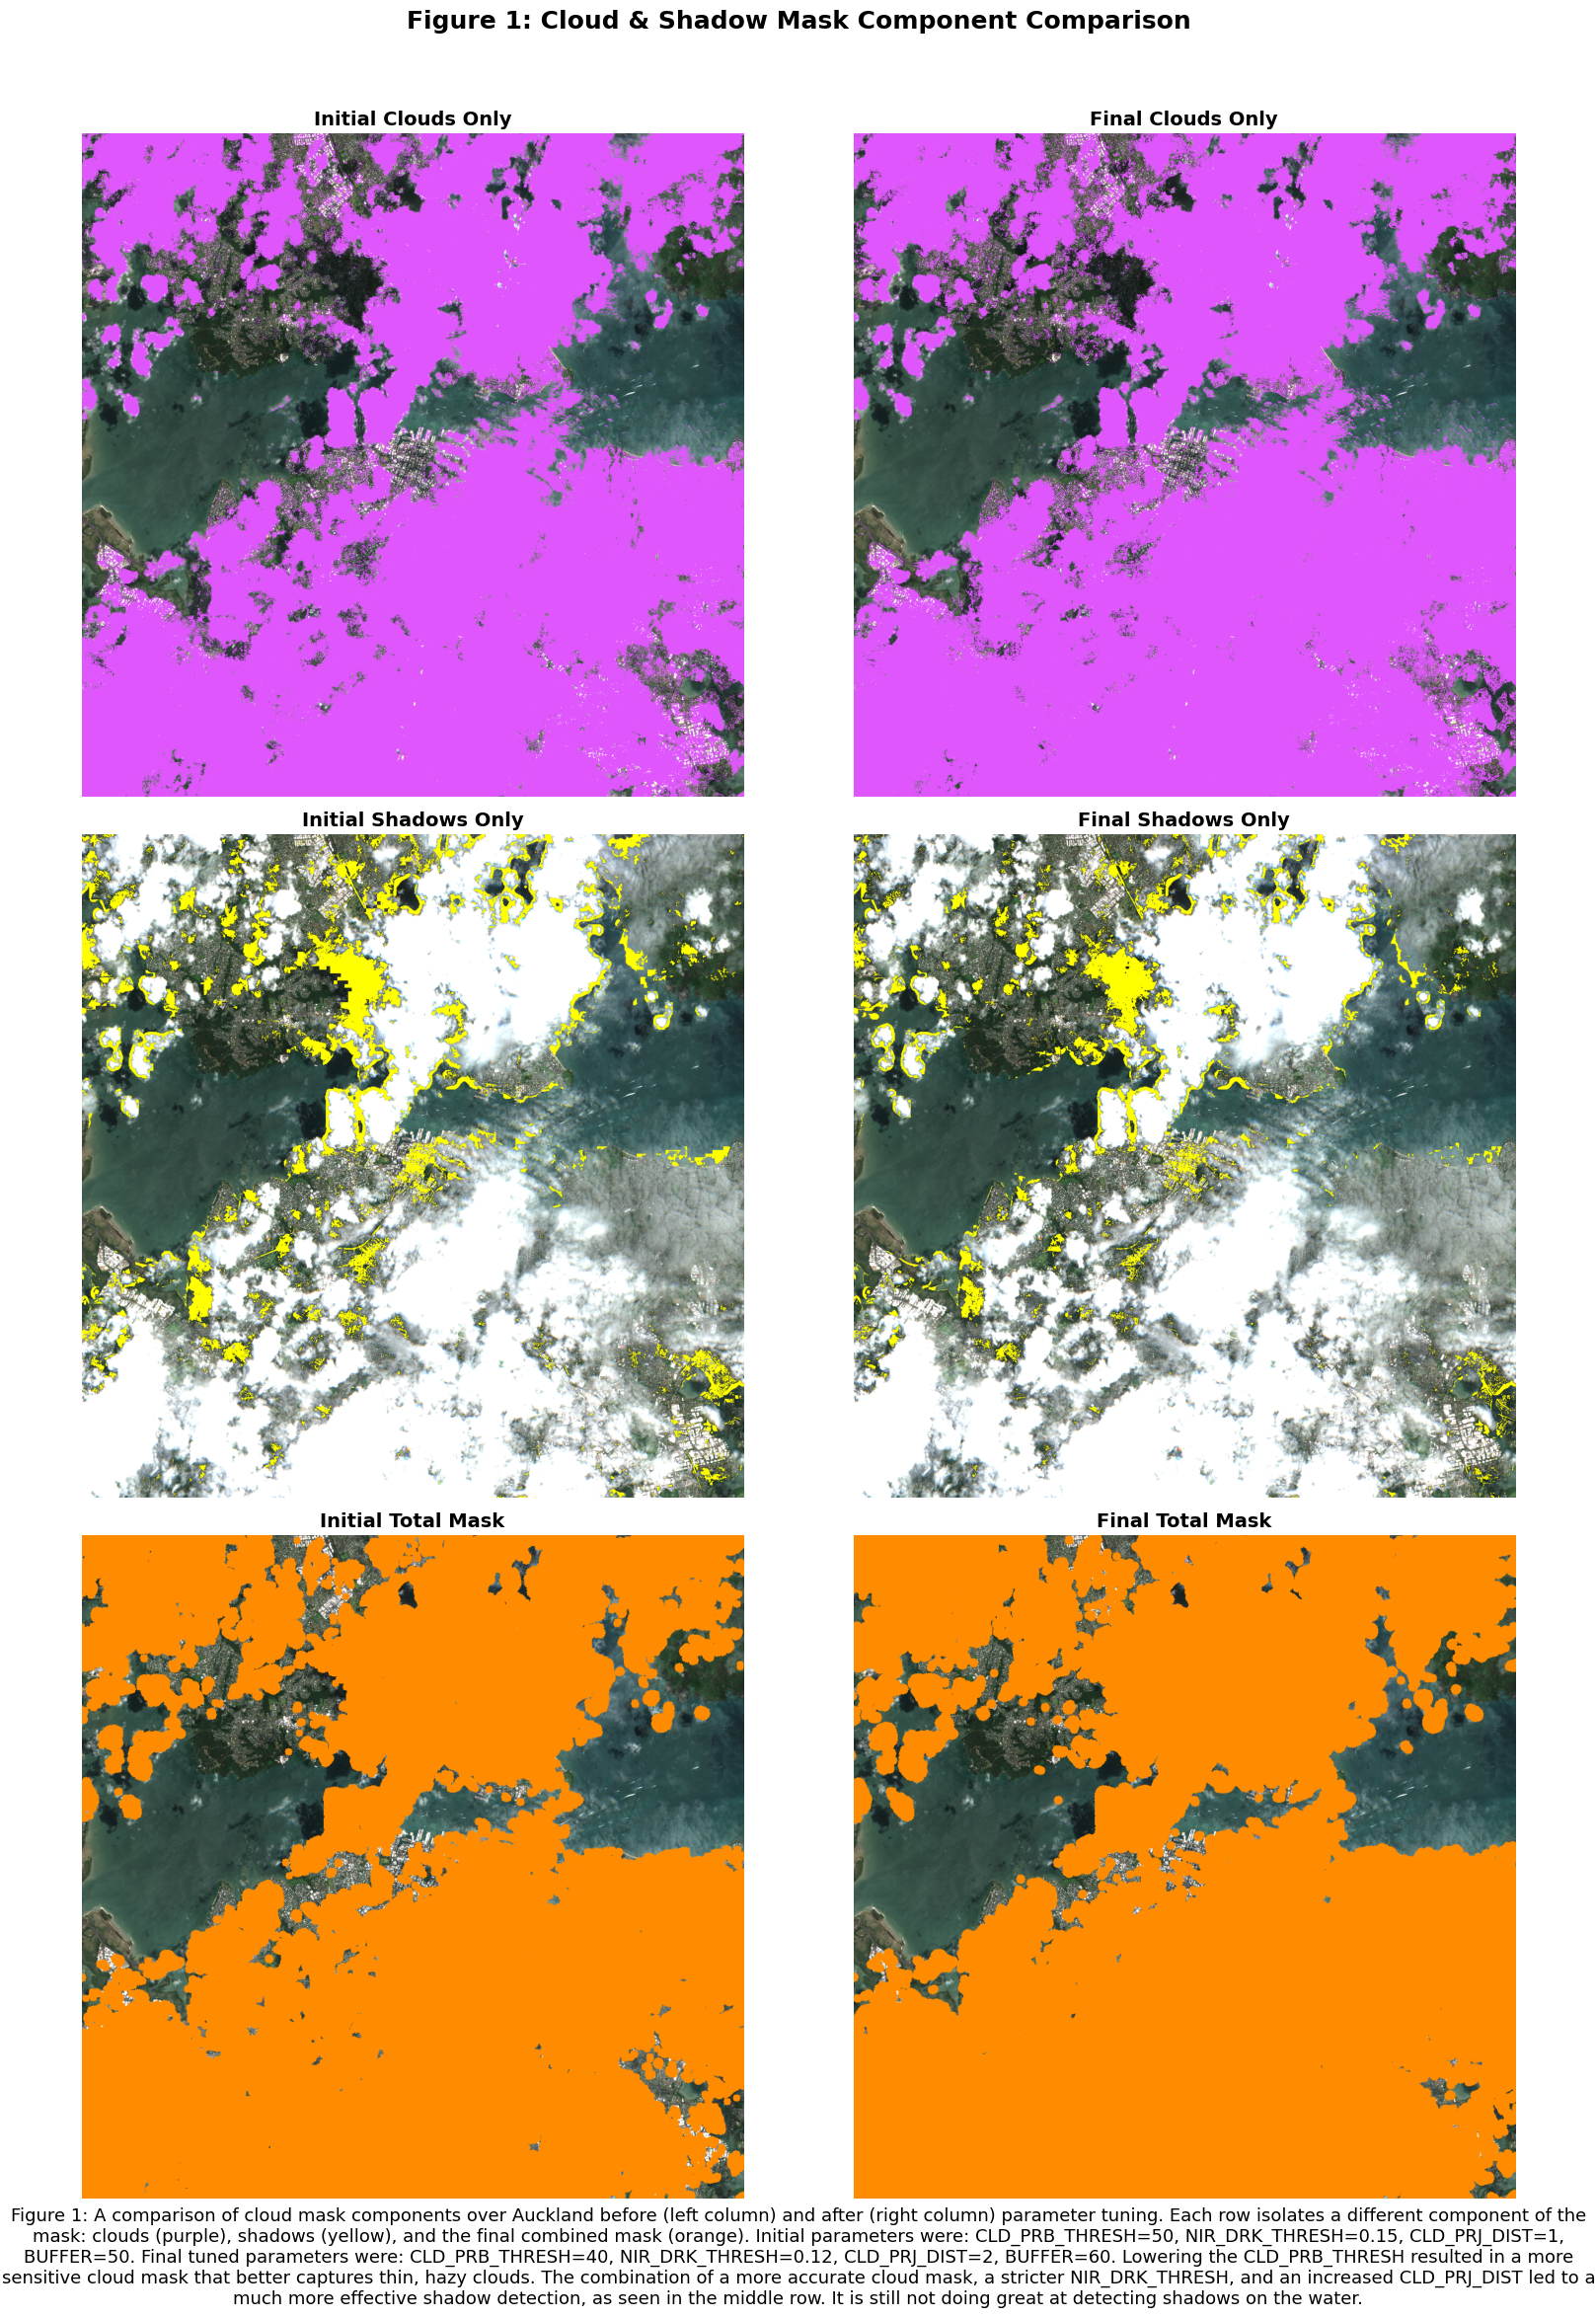

In [ ]:
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np

# ====================================================================================
# === USER-PROVIDED GOOGLE EARTH ENGINE FUNCTIONS START HERE ===
# ====================================================================================

def get_s2_sr_cld_col(aoi, start_date, end_date, cloud_filter):
    """Imports and filters the Sentinel-2 Surface Reflectance and Cloud Probability collections."""
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', cloud_filter)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

def add_cloud_bands(img, cld_prb_thresh):
    """Adds cloud probability and a binary cloud mask to an image."""
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')
    is_cloud = cld_prb.gt(cld_prb_thresh).rename('clouds')
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img, nir_drk_thresh, cld_prj_dist):
    """Adds cloud shadow component bands to an image."""
    not_water = img.select('SCL').neq(6)
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(nir_drk_thresh * SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')))
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, cld_prj_dist * 10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img, params):
    """Applies the full cloud and shadow masking algorithm to an image using a dictionary of parameters."""
    img_cloud = add_cloud_bands(img, params['CLD_PRB_THRESH'])
    img_cloud_shadow = add_shadow_bands(img_cloud, params['NIR_DRK_THRESH'], params['CLD_PRJ_DIST'])
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(params['BUFFER'] * 2 / 20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))
    return img_cloud_shadow.addBands(is_cld_shdw)

# ====================================================================================
# === PLOTTING AND VISUALIZATION FUNCTIONS START HERE ===
# ====================================================================================

def apply_cloud_only_visualization(ee_image):
    """Visualizes ONLY the 'clouds' band on the true-color image."""
    rgb_vis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000, 'gamma': 1.1}
    background = ee_image.visualize(**rgb_vis)
    cloud_vis = ee_image.select('clouds').selfMask().visualize(**{'palette': ['#e056fd']}) # Purple
    return background.blend(cloud_vis)

def apply_shadow_only_visualization(ee_image):
    """Visualizes ONLY the 'shadows' band on the true-color image."""
    rgb_vis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000, 'gamma': 1.1}
    background = ee_image.visualize(**rgb_vis)
    shadow_vis = ee_image.select('shadows').selfMask().visualize(**{'palette': ['#FFFF00']}) # Yellow
    return background.blend(shadow_vis)

def apply_total_mask_visualization(ee_image):
    """Applies visualization parameters to show the final combined mask over the true-color image."""
    rgb_vis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000, 'gamma': 1.1}
    background = ee_image.visualize(**rgb_vis)
    mask_vis = ee_image.select('cloudmask').selfMask().visualize(**{'palette': ['#FF8C00']}) # Orange
    return background.blend(mask_vis)


def create_comparison_figure(arrays, caption_text, output_filename):
    """Creates and saves a 3x2 comparison figure from image data arrays."""
    fig, axes = plt.subplots(3, 2, figsize=(16, 24))

    # Define titles for each panel
    titles = [
        'Initial Clouds Only', 'Final Clouds Only',
        'Initial Shadows Only', 'Final Shadows Only',
        'Initial Total Mask', 'Final Total Mask'
    ]

    # Flatten the axes array for easy iteration and assign images and titles
    ax_flat = axes.flatten()
    for i, arr in enumerate(arrays):
        ax_flat[i].imshow(arr)
        ax_flat[i].set_title(titles[i], fontsize=14, weight='bold')
        ax_flat[i].axis('off')

    # Add shared elements
    fig.text(0.5, 0.01, caption_text, ha='center', va='bottom', wrap=True, fontsize=13)
    plt.suptitle('Figure 1: Cloud & Shadow Mask Component Comparison', fontsize=18, weight='bold')
    fig.tight_layout(rect=[0, 0.05, 1, 0.96]) # Adjust layout for caption
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Figure saved successfully as '{output_filename}'")

# ====================================================================================
# === MAIN EXECUTION BLOCK ===
# ====================================================================================
if __name__ == '__main__':
    # --- 1. Define Parameters and Region ---
    AOI = ee.Geometry.Point(174.7633, -36.8485)
    START_DATE = '2023-01-01'
    END_DATE = '2023-03-31'
    CLOUD_FILTER = 60
    region = AOI.buffer(9000).bounds()

    initial_params = {'CLD_PRB_THRESH': 50, 'NIR_DRK_THRESH': 0.15, 'CLD_PRJ_DIST': 1, 'BUFFER': 50}
    final_params = {'CLD_PRB_THRESH': 40, 'NIR_DRK_THRESH': 0.12, 'CLD_PRJ_DIST': 2, 'BUFFER': 60}

    # --- 2. Run Full GEE Analysis ---
    print("Fetching image collection from GEE...")
    s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE, CLOUD_FILTER)
    image_to_process = ee.Image(s2_sr_cld_col.first())

    print("Running analysis with initial parameters...")
    initial_ee_image = add_cld_shdw_mask(image_to_process, initial_params)

    print("Running analysis with final parameters...")
    final_ee_image = add_cld_shdw_mask(image_to_process, final_params)

    # --- 3. Apply Visualization and Convert to NumPy Arrays ---
    print("Generating image thumbnails from GEE... (This may take a moment)")
    # Generate arrays for the cloud component
    initial_cloud_array = geemap.ee_to_numpy(apply_cloud_only_visualization(initial_ee_image), region=region)
    final_cloud_array = geemap.ee_to_numpy(apply_cloud_only_visualization(final_ee_image), region=region)

    # Generate arrays for the shadow component
    initial_shadow_array = geemap.ee_to_numpy(apply_shadow_only_visualization(initial_ee_image), region=region)
    final_shadow_array = geemap.ee_to_numpy(apply_shadow_only_visualization(final_ee_image), region=region)

    # Generate arrays for the total cloud+shadow mask
    initial_mask_array = geemap.ee_to_numpy(apply_total_mask_visualization(initial_ee_image), region=region)
    final_mask_array = geemap.ee_to_numpy(apply_total_mask_visualization(final_ee_image), region=region)

    # --- 4. Create and Save the Figure ---
    figure_caption = (
        "Figure 1: A comparison of cloud mask components over Auckland before (left column) and after (right column) parameter tuning. "
        "Each row isolates a different component of the mask: clouds (purple), shadows (yellow), and the final combined mask (orange). "
        "Initial parameters were: CLD_PRB_THRESH=50, NIR_DRK_THRESH=0.15, CLD_PRJ_DIST=1, BUFFER=50. "
        "Final tuned parameters were: CLD_PRB_THRESH=40, NIR_DRK_THRESH=0.12, CLD_PRJ_DIST=2, BUFFER=60. "
        "Lowering the CLD_PRB_THRESH resulted in a more sensitive cloud mask that better captures thin, hazy clouds. "
        "The combination of a more accurate cloud mask, a stricter NIR_DRK_THRESH, and an increased CLD_PRJ_DIST led to a much more effective shadow detection, as seen in the middle row. "
        "It is still not doing great at detecting shadows on the water."
    )
    output_file = 'comparison_figure_3x2.png'

    arrays_to_plot = [
        initial_cloud_array, final_cloud_array,
        initial_shadow_array, final_shadow_array,
        initial_mask_array, final_mask_array
    ]

    print("Creating final figure...")
    create_comparison_figure(arrays_to_plot, figure_caption, output_file)


(2) Exercise: change the above CLD_PRB_THRESH, NIR_DRK_THRESH, CLD_PRJ_DIST, and BUFFER input variables and rerun the previous cells to see how the results change. Present a figure that compares between the first version you ran and your final version. State the values you have selected and describe the improvements in performance you have managed to achieve in the figure caption.

(10 pts)

Finally for this section, let's apply this cloud mask to our data and generate a 'cloud free' image. Replace my parameters used below with the ones you have selected based on your answer to question 2.

In [ ]:
# Tweaked control variables
AOI = ee.Geometry.Point(174.7633, -36.8485)
START_DATE = '2023-01-01'
END_DATE = '2023-03-31'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 40
NIR_DRK_THRESH = 0.12
CLD_PRJ_DIST = 2
BUFFER = 60

# Re-collect the S2 as we have changed our filtering params
s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

In [ ]:
# Define a function to apply the cloud mask to the S2 spectral bands
def apply_cld_shdw_mask(img):
    cloudmask = img.select('cloudmask')
    # Mask cloudy pixels
    masked_img = img.updateMask(cloudmask.Not())
    # Keep cloudmask and probability bands
    cloudmask_band = img.select('cloudmask')
    probability_band = img.select('probability')
    masked_img = masked_img.addBands([cloudmask_band, probability_band], overwrite=True)
    return masked_img

In [ ]:
# Process the collection
s2_sr_median = (s2_sr_cld_col.map(lambda img: add_cld_shdw_mask(img, CLD_PRJ_DIST))
                             .map(apply_cld_shdw_mask)
                             .median())

In [ ]:
# Display the cloud free composite
def display_cloud_free_mosaic(s2_sr_median, AOI):
    # Create a geemap Map object and center it on the AOI
    m = geemap.Map()
    m.centerObject(AOI, 12)

    # Add the Sentinel-2 RGB mosaic
    m.addLayer(
        s2_sr_median,
        {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
        'S2 cloud-free mosaic')

    return m

display_map = display_cloud_free_mosaic(s2_sr_median, AOI)
display_map

Map(center=[-36.84850000000001, 174.7633], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

Now THAT is a cloud-free image! (Well, with my thresholds we still have a little there over the SW forest, can yours do better?).

(3) This process has managed to avoid masking out the many bright white roofs of Auckland as cloud, despite them appearing very similar to cloud in the RGB visualization. How has the algorithm achieved this?
(5 pts)


________________________________________________________________________________

# Extending S2 Cloudless with a clustering approach
The process we explored in the prior section has worked really rather well! But you saw in the exercise that it does rely on you setting the local paramaters. This is a manual process and one that is at risk of reduced effectiveness if we are clearing cloud over a wide area. This is particularly the case for cirrus and other thin clouds (e.g. cloud edges) that the thresholds are very sensitive to.

Therefore, let us extend our cloud-clearing algorithim into one that includes a clustering-step in which we sample the pixels around the edge of our clouds and test if they should be clustered into our cloud mask.

We will now implement the following workflow:
1.   Reset our data stack, with somewhat worse settings than the very good ones we have just set, in order to make this a better (for humans) teaching exercise.
2.   Define what counts as inside a cloud, outside a cloud and the edge of a cloud.
3.   Vizualize these samples and determine if we can perform meaningful clustering on them.
4.   Perform clustering of the border zone pixels with either the clouds or the cloud free.





In [ ]:
# First, lets make our cloud clearing 'worse' in order to more clearly demonstrate our clustering alg
# Tweaked control variables
AOI = ee.Geometry.Point(174.7633, -36.8485)
START_DATE = '2023-01-01'
END_DATE = '2023-03-31'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 40
NIR_DRK_THRESH = 0.12
CLD_PRJ_DIST = 2
BUFFER = 60

# Re-collect the S2 as we have changed our filtering params
s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

# Re-run s2cloudless approach, this time with .moasic as the compositing operator
s2_sr_mosaic = (s2_sr_cld_col.map(lambda img: add_cld_shdw_mask(img, CLD_PRJ_DIST))
                             .map(apply_cld_shdw_mask)
                             .mosaic()) #<- switched to mosaic to better preserve the cloud masking layers we want to now use for our k-means workflow

In [ ]:
def define_cloud_zones(img, edge_buffer=120):
    cloudmask = img.select('cloudmask')

    # Interior cloud pixels: cloudmask==1, away from edges (small erosion)
    cloud_interior = cloudmask.selfMask().focal_min(3)

    # Interior clear pixels: cloudmask==0, away from edges (medium erosion)
    clear_interior = cloudmask.Not().selfMask().focal_min(10)

    # Cloud edge pixels: buffer zone around clouds, but outside cloudmask
    cloud_edge = cloudmask.focal_max(edge_buffer / 10).And(cloudmask.Not())

    return cloud_interior, clear_interior, cloud_edge


In [ ]:
def sample_zones(img, AOI, edge_buffer=20):
    cloudmask = img.select('cloudmask')

    cloud_interior = cloudmask.selfMask()
    clear_interior = cloudmask.Not().selfMask()
    cloud_edge = cloudmask.focal_max(edge_buffer).And(cloudmask.Not())

    sample_bands = ['B2', 'B3', 'B4', 'B5', 'B6' , 'B9', 'B8', 'B11', 'B12']
    if 'probability' in img.bandNames().getInfo():
        sample_bands.append('probability')

    # I added the else statement for debugging reasons
    else:
      print("No probability")

    img_for_sampling = img.select(sample_bands)

    cloud_samples = img_for_sampling.updateMask(cloud_interior).sample(
        region=AOI.buffer(2000), scale=10, numPixels=5000, seed=0, geometries=True)

    clear_samples = img_for_sampling.updateMask(clear_interior).sample(
        region=AOI.buffer(2000), scale=10, numPixels=5000, seed=1, geometries=True)

    edge_samples = img_for_sampling.updateMask(cloud_edge).sample(
        region=AOI.buffer(2000), scale=10, numPixels=5000, seed=2, geometries=True)

    return cloud_samples, clear_samples, edge_samples


In [ ]:
# Gather our samples
cloud_samples, clear_samples, edge_samples = sample_zones(s2_sr_mosaic, AOI)

# Function to convert a earth engine feature class to a pandas df
def fc_to_df(fc):
    features = fc.getInfo()['features']
    rows = []
    for f in features:
        props = f['properties']
        coords = f['geometry']['coordinates']
        props['longitude'] = coords[0]
        props['latitude'] = coords[1]
        rows.append(props)
    return pd.DataFrame(rows)


# Carry out the conversion and sanity print out what we have
cloud_df = fc_to_df(cloud_samples)
clear_df = fc_to_df(clear_samples)
edge_df = fc_to_df(edge_samples)

print(f"Cloud samples: {len(cloud_df)}")
print(f"Clear samples: {len(clear_df)}")
print(f"Edge samples: {len(edge_df)}")
print("Cloud columns:", cloud_df.columns)


Cloud samples: 548
Clear samples: 4404
Edge samples: 740
Cloud columns: Index(['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B8', 'B9', 'probability',
       'longitude', 'latitude'],
      dtype='object')


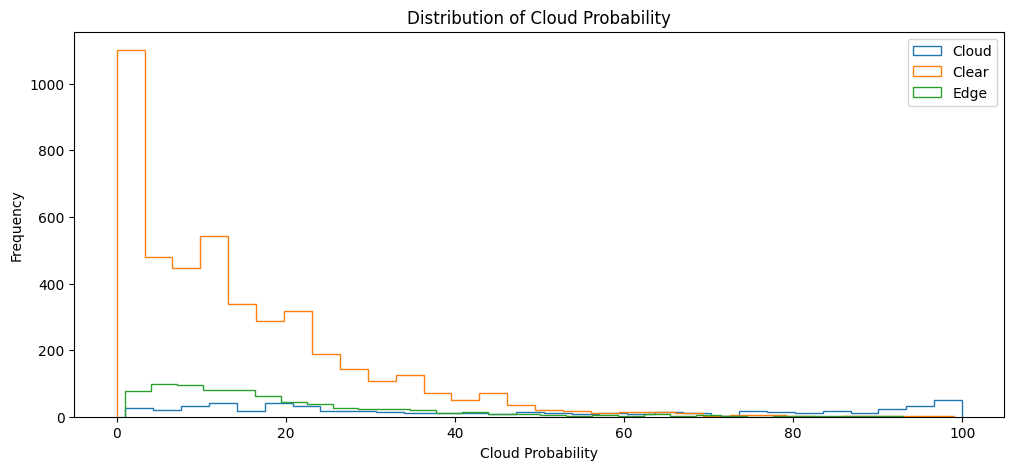

In [ ]:
# Histogram of cloud probability by class
plt.figure(figsize=(12, 5))
plt.hist(cloud_df['probability'], bins=30, histtype='step', label='Cloud')
plt.hist(clear_df['probability'], bins=30, histtype='step', label='Clear')
plt.hist(edge_df['probability'], bins=30, histtype='step', label='Edge')
plt.xlabel('Cloud Probability')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Cloud Probability')
plt.show()

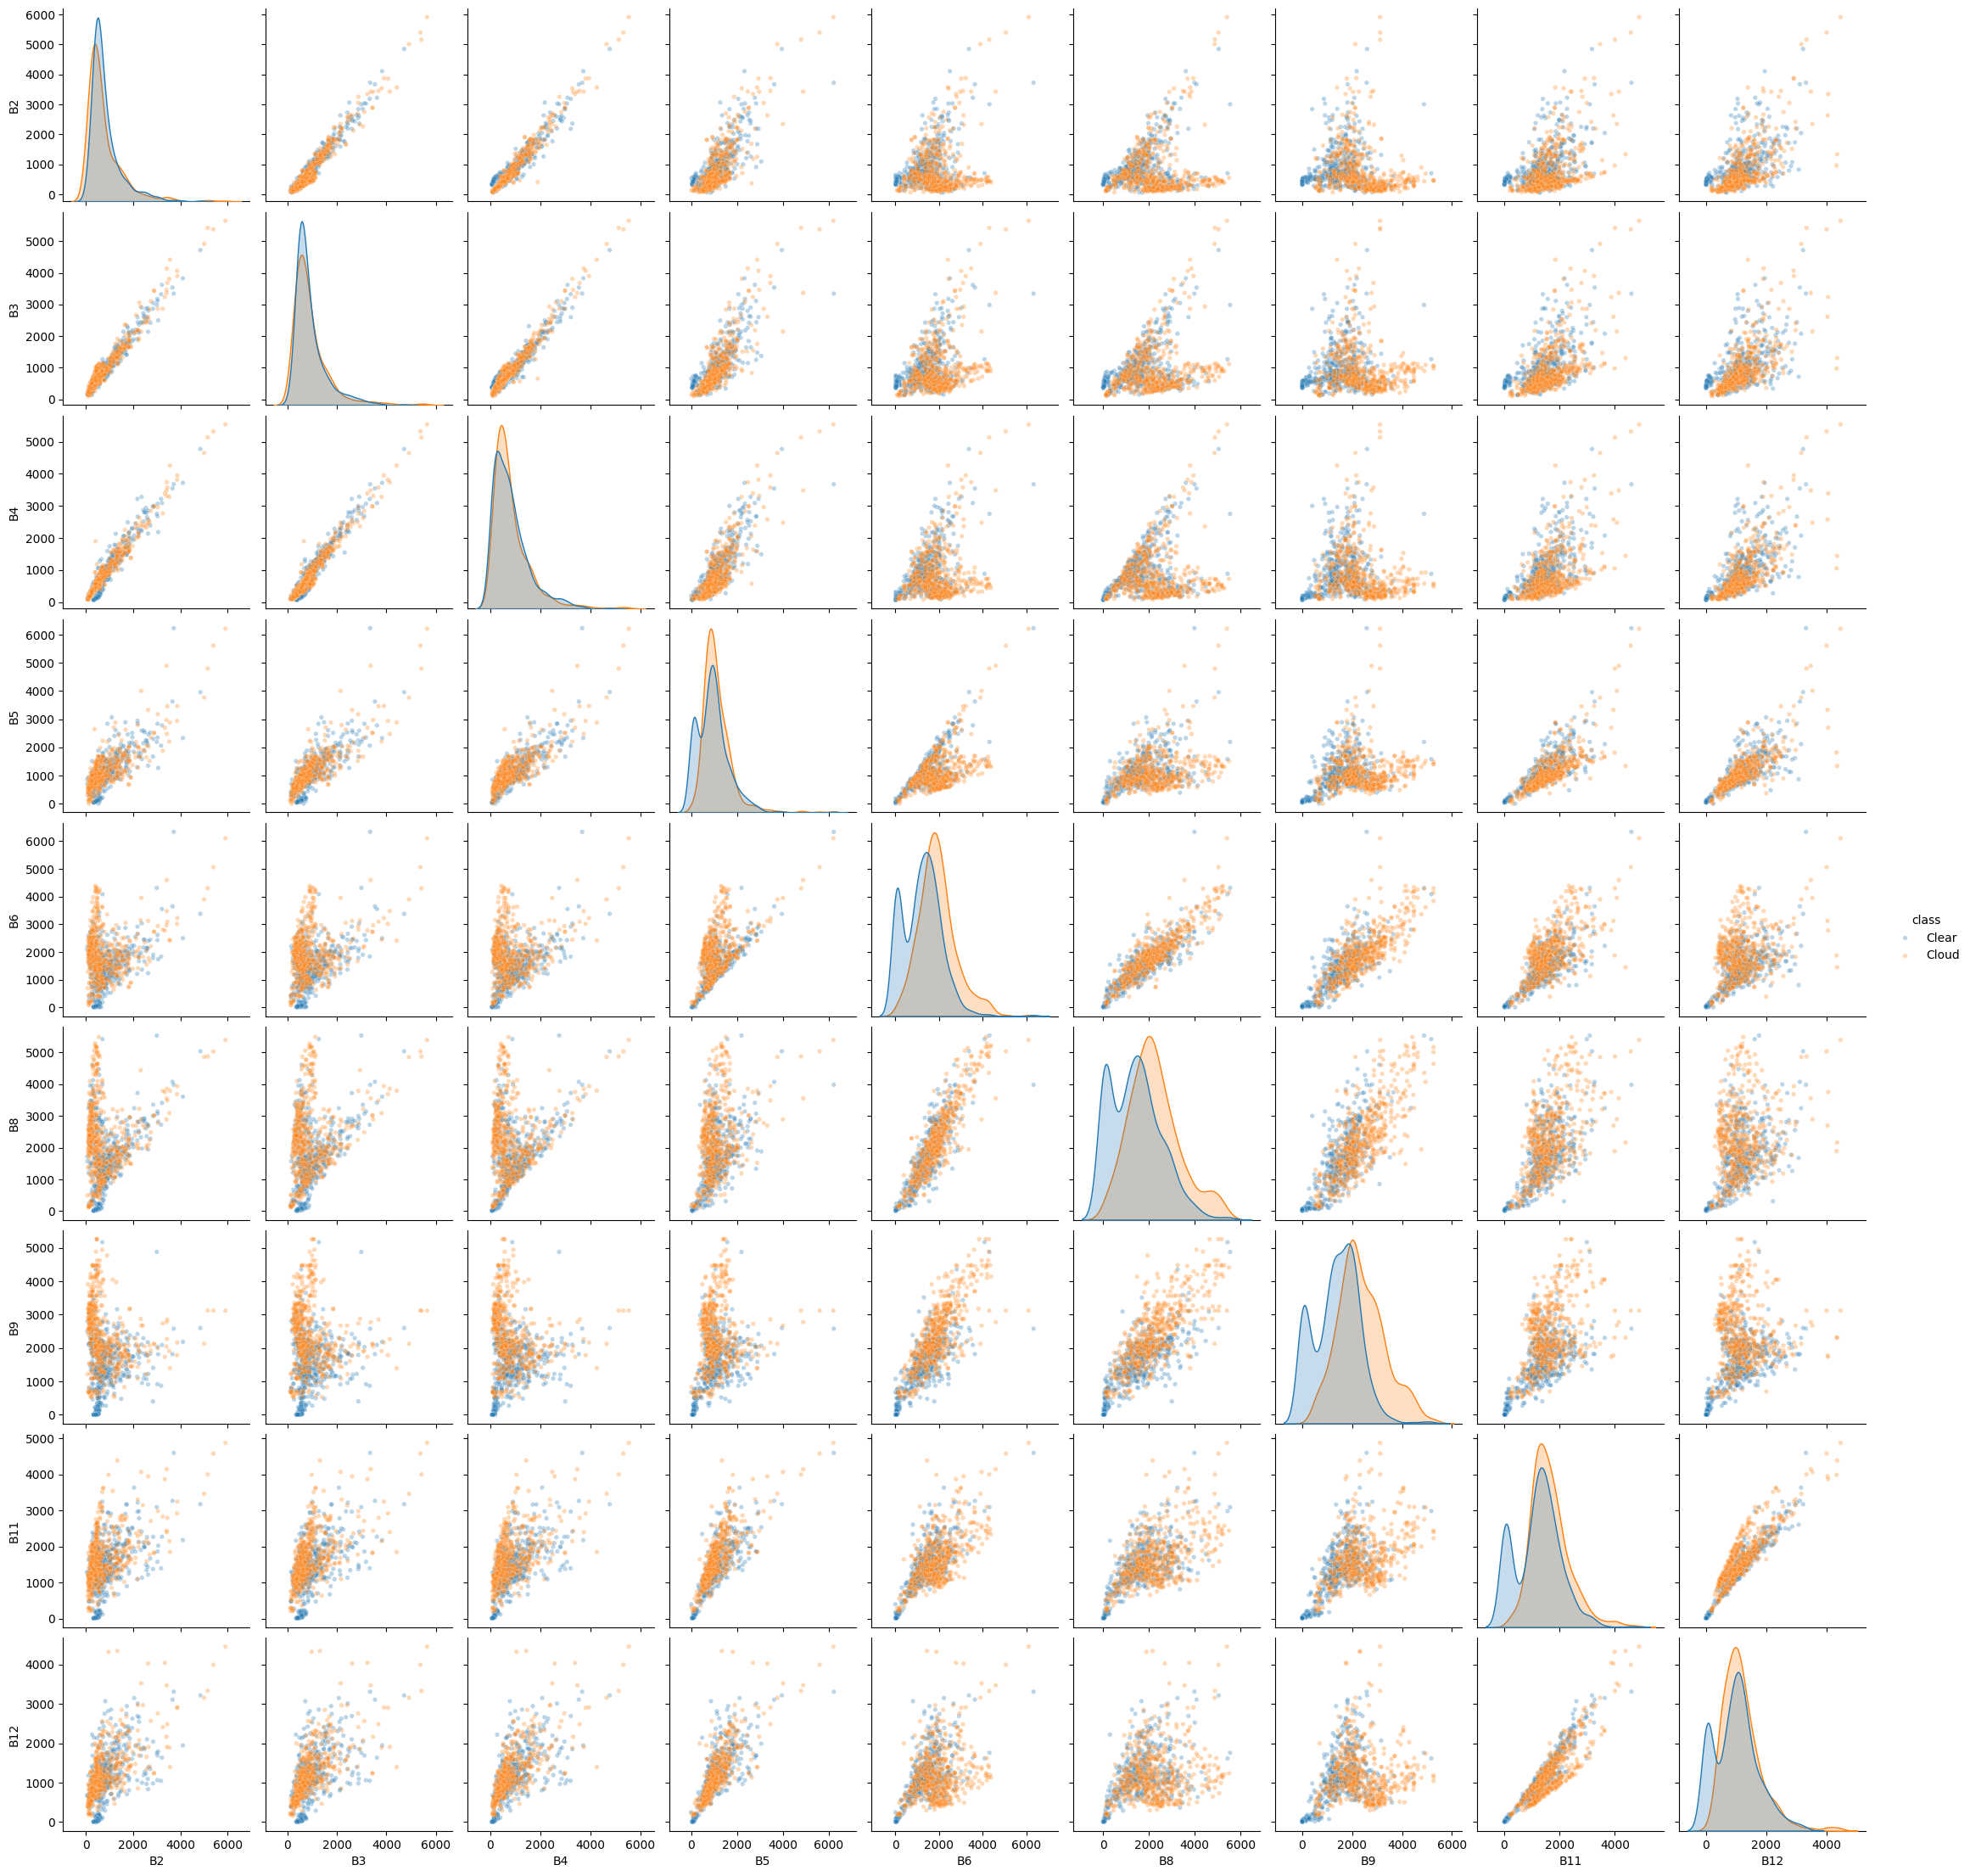

In [ ]:
# Plot out all the bands, by the two 'labelled' classes that we want to discriminate between
# Add class labels
cloud_df['class'] = 'Cloud'
clear_df['class'] = 'Clear'

# Combine to one df
combined_df = pd.concat([cloud_df, clear_df])

# We will carry out somne class balancing here
# Find smallest class count
min_count = combined_df['class'].value_counts().min()

# Downsample each class to min_count
balanced_df = combined_df.groupby('class').sample(n=min_count, random_state=42)

# Now plot with balanced_df
# This is going to make a big plot that you will have to scroll around! Pay particular attention to the histogram plots on the diagonal.
bands = ['B2', 'B3', 'B4', 'B5', 'B6' , 'B8', 'B9', 'B11', 'B12']
sns.pairplot(balanced_df, vars=bands, hue='class', plot_kws={'alpha':0.3, 's':15}, height=2.5)


(4) What do the histograms of cloud detection probability (as judged by s2cloudless) plotted in the three classes we have set here, AND the pair plot of all bands available tell us about our ability to tell cloudy vs non-cloud pixels apart? Make sure to explain your answer with reference to physical principles and the statistical foundations of ML (5 pts)

(5) Which bands are therefore going to be the best to use in our K-means clustering approach and why? (5 pts)

With our choices made, let us now test if we can implement k-means as a tool by which to assign those edge pixels into either the cloudy or clear classes. Noting that I have placed default band choices in the 'features to use for clustering' line. You do not need to use just three bands.

Run this section first with the default bands, and then change it to the ones you have selected in question 5. Observe the difference it makes...

In [ ]:
# Use the balanced_df from before for cloud and clear pixels only
train_df = balanced_df[balanced_df['class'].isin(['Cloud', 'Clear'])]

# Features to use for clustering
features = ['B2', 'B8', 'B9', 'B11', 'probability']

# Prepare training data (cloud=1, clear=0)
X_train = train_df[features].values
y_train = (train_df['class'] == 'Cloud').astype(int).values

# Fit k-means with 2 clusters on training data
kmeans = KMeans(n_clusters=2, random_state=42).fit(X_train)

# Map clusters to classes by majority vote on training data
labels, counts = np.unique(kmeans.labels_[y_train==0], return_counts=True)
clear_cluster = labels[np.argmax(counts)]
labels, counts = np.unique(kmeans.labels_[y_train==1], return_counts=True)
cloud_cluster = labels[np.argmax(counts)]

# Prepare edge pixels data for prediction
edge_features = edge_df[features].values

# Predict clusters for edge pixels
edge_clusters = kmeans.predict(edge_features)

# Assign class labels to edge pixels based on cluster
edge_df['predicted_class'] = ['Cloud' if c == cloud_cluster else 'Clear' for c in edge_clusters]

# Quick summary
print(edge_df['predicted_class'].value_counts())


predicted_class
Cloud    459
Clear    281
Name: count, dtype: int64


And now plot up the results of this below. Play around with this plotting and take a look at each set of band combinations you have chosen. Think about where the boundary is being placed, does it make sense?

predicted_class
Cloud    459
Clear    281
Name: count, dtype: int64


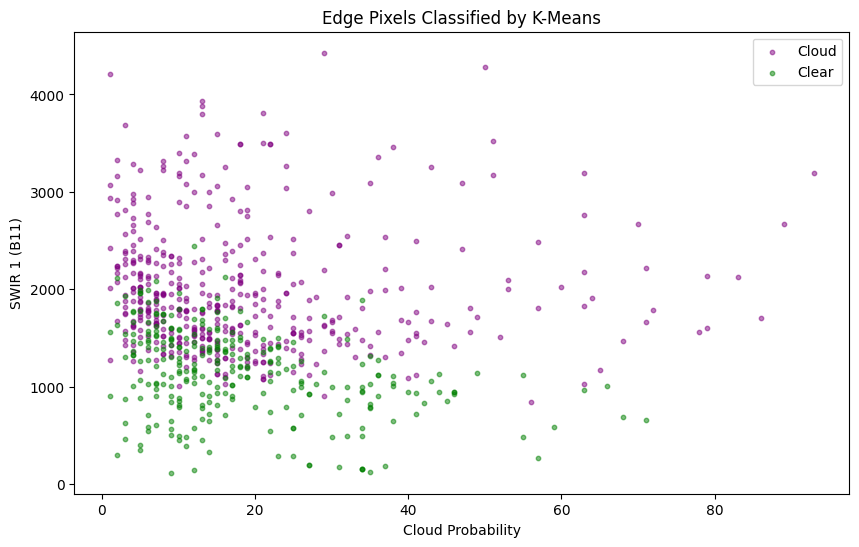

In [ ]:
# Count of predicted classes
counts = edge_df['predicted_class'].value_counts()
print(counts)

# Scatter plot of edge pixels B4 vs B3 colored by predicted class ### CHANGE THIS TO YOUR OTHER BANDS ###
plt.figure(figsize=(10, 6))
for label, color in zip(['Cloud', 'Clear'], ['purple', 'green']):
    subset = edge_df[edge_df['predicted_class'] == label]
    plt.scatter(subset['probability'], subset['B11'], label=label, alpha=0.5, s=10, c=color)

plt.xlabel('Cloud Probability')
plt.ylabel('SWIR 1 (B11)')
plt.title('Edge Pixels Classified by K-Means')
plt.legend()
plt.show()


Finally, we will map this back onto earth engine via the following workflow:
1.  Export the classified edge pixels back to Earth Engine as a FeatureCollection
2. Rasterize the classified edge points into an image layer
3. Visualize refined cloud mask in Earth Engine (geemap):

Export to Earth Engine FC:

In [ ]:
# Function to go the other way! This time from a dataframe to the feature collection
def df_to_ee_fc(df):
    features = []
    for _, row in df.iterrows():
        geom = ee.Geometry.Point([row['longitude'], row['latitude']])
        props = {k: float(row[k]) for k in ['B2', 'B8', 'B9', 'B11', 'probability']}
        props['predicted_class'] = row['predicted_class']
        features.append(ee.Feature(geom, props))
    return ee.FeatureCollection(features)

edge_fc = df_to_ee_fc(edge_df)

Rasterize into image layer:

In [ ]:
# Map predicted class to numeric
def class_to_numeric(feature):
    cls = feature.get('predicted_class')
    return feature.set('cloud_refined', ee.Number(ee.Algorithms.If(ee.String(cls).equals('Cloud'), 1, 0)))

edge_fc_num = edge_fc.map(class_to_numeric)

# Rasterize: paint 'cloud_refined' on a blank image
refined_cloud_mask = edge_fc_num.reduceToImage(
    properties=['cloud_refined'],
    reducer=ee.Reducer.first())

# Optionally, you can combine this refined mask with your existing cloudmask for a final refined mask
final_mask = s2_sr_mosaic.select('cloudmask').max(refined_cloud_mask).rename('cloudmask_refined')


Visualize it:

In [ ]:
Map = geemap.Map()
Map.centerObject(AOI, 12)

# Show original cloudmask
Map.addLayer(s2_sr_median.select('cloudmask'), {'palette': ['white', 'red']}, 'Original cloudmask')

# Show refined cloudmask
Map.addLayer(final_mask.selfMask(), {'palette': ['blue']}, 'Refined cloudmask')

Map

Map(center=[-36.84850000000001, 174.7633], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

Hopefully, what you should now see above is a patch of downtown Auckland that has your s2cloudless cloudmask and a scatter of blue pixels (i.e. the sample from within the AOI) that k-means has decided is cloud.

Your answer to Q5 should see this scatter of 'new cloudy' pixels be better associated with the known clouds than if you leave it as the default bands that I have provided.





(6) Exercise: take all you have learned in this lab and carry out the following improvements:
1. Increase the K-means sampling to be more representative of the whole scene. This means; sample regions for cloud, clear and cloud edge that are not just over downtown Auckland but from across multiple landcover types.
2. Take the model that you have trained here using SciKitLearn and use it to classify edge pixels across a whole satellite image.

Present your results in **two** figures. The first should show the results of upgrades to pt.1, the second the results of pt.2.

(15 pts)

To get you started on item 2, this might be how you plan out your workflow given that you cannot upload a python ML model directly to Earth Engine:
- Extract cluster centres from Python k-means.
- Pass centres as constants into EE.
- Write a per-pixel classification function assigning nearest cluster centre.
- Apply this function to edge pixels or the whole image as needed.

In [ ]:
# 1. Increase the K-means sampling to be more representative of the whole scene.
# This means; sample regions for cloud, clear and cloud edge that are not just over downtown Auckland
# but from across multiple landcover types.

# A larger bounding box to ensure all our regions are covered
study_area = ee.Geometry.Rectangle([174.4, -37.1, 175.1, -36.7])

# Define specific zones for sampling
urban_zone = ee.Geometry.Rectangle([174.7, -36.9, 174.85, -36.8])
forest_zone = ee.Geometry.Rectangle([174.5, -37.0, 174.65, -36.9])
rural_zone = ee.Geometry.Rectangle([174.8, -37.1, 175.0, -37.0])
water_zone = ee.Geometry.Rectangle([174.9, -36.9, 175.0, -36.8])

# Combine all zones into a single MultiPolygon for sampling
sampling_regions = ee.Geometry.MultiPolygon(
    [urban_zone, forest_zone, rural_zone, water_zone]
)

# Re-collect the S2 as we have changed our filtering params
s2_sr_cld_col = get_s2_sr_cld_col(study_area, START_DATE, END_DATE)

# Re-run s2cloudless approach, this time with .mosaic as the compositing operator
s2_sr_mosaic = (s2_sr_cld_col.map(lambda img: add_cld_shdw_mask(img, CLD_PRJ_DIST))
                           .map(apply_cld_shdw_mask)
                           .mosaic())

# --- K-Means Clustering with improved sampling ---
cloud_samples, clear_samples, edge_samples = sample_zones(s2_sr_mosaic, sampling_regions)
cloud_df = fc_to_df(cloud_samples)
clear_df = fc_to_df(clear_samples)
edge_df = fc_to_df(edge_samples)

# (The rest of the K-means and plotting code remains the same)
# ...



KeyboardInterrupt: 

In [ ]:
# Display final map
Map = geemap.Map()
Map.centerObject(study_area, 10) # Center on the larger study area
Map.addLayer(sampling_regions, {'color': 'yellow'}, 'Sampling Zones') # Visualize the zones
Map.addLayer(s2_sr_mosaic.select('cloudmask'), {'palette': ['white', 'red']}, 'Original cloudmask')
# Show refined cloudmask
Map.addLayer(final_mask.selfMask(), {'palette': ['blue']}, 'Refined cloudmask')
Map

In [ ]:

cloud_df['class'] = 'Cloud'
clear_df['class'] = 'Clear'
combined_df = pd.concat([cloud_df, clear_df])
min_count = combined_df['class'].value_counts().min()
balanced_df = combined_df.groupby('class').sample(n=min_count, random_state=42)

X_train = balanced_df[features].values
y_train = (balanced_df['class'] == 'Cloud').astype(int).values

print("Training K-Means model in Python...")
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10).fit(X_train)


In [ ]:
# Extract Cluster Centers from Python ---
cluster_centers = kmeans.cluster_centers_
print("Extracted Cluster Centers:\n", cluster_centers)

# Map clusters to classes (0 or 1)
labels, counts = np.unique(kmeans.labels_[y_train==0], return_counts=True)
clear_cluster_id = labels[np.argmax(counts)]
cloud_cluster_id = 1 - clear_cluster_id
print(f"Cloud cluster ID is: {cloud_cluster_id}")

In [ ]:
# Create and Apply GEE Classifier (Server-Side)

def classify_image_gee(img, centers, cloud_id, bands):
    """Classifies an image per-pixel using pre-trained cluster centers."""
    centers_ee = ee.Array(centers)
    img_bands = img.select(bands)
    img_array = img_bands.toArray()

    # Calculate squared difference. Broadcasting will handle dimensions.
    sq_diff = img_array.subtract(centers_ee.transpose()).pow(2)

    # Sum the squared differences along the feature axis (0).
    distances = sq_diff.arrayReduce(ee.Reducer.sum(), [0]).arrayProject([1])

    # Extract the distance to each of the two cluster centers
    dist_to_c0 = distances.arrayGet([0])
    dist_to_c1 = distances.arrayGet([1])

    # Assign cluster ID 0 or 1 based on which distance is smaller
    closest_cluster = ee.Image(0).where(dist_to_c1.lt(dist_to_c0), 1).rename('cluster')

    # Return a binary image: 1 if the pixel belongs to the cloud cluster, 0 otherwise
    return closest_cluster.eq(cloud_id)

In [ ]:
# Apply to the full image

print("Applying trained model to the full image in Earth Engine...")
# Define the ambiguous edge zone for classification
_, _, edge_zone = define_cloud_zones(s2_sr_mosaic)

# Classify the entire mosaic
classified_image = classify_image_gee(s2_sr_mosaic, cluster_centers.tolist(), cloud_cluster_id, features)

# Apply the classification ONLY to the edge pixels
refined_edge_mask = classified_image.updateMask(edge_zone)

# Combine the original mask with the newly classified edge pixels
final_refined_mask = s2_sr_mosaic.select('cloudmask').unmask(0).Or(refined_edge_mask).rename('cloudmask_refined')

# Task
Improve the cloud masking process by: 1. Increasing the K-means sampling to be more representative of the whole scene by sampling regions for cloud, clear, and cloud edge from across multiple landcover types. 2. Using the trained SciKitLearn K-means model to classify edge pixels across a whole satellite image in Earth Engine. Present the results in two figures: the first showing the results of the improved sampling, and the second showing the results of the edge pixel classification.

## Implement broader sampling regions

### Subtask:
Modify the `sample_zones` function to accept a list of geometries and sample from all of them to get a more representative training dataset.


**Reasoning**:
The task requires modifying the `sample_zones` function to accept multiple sampling regions and then calling this modified function with the defined regions. This involves updating the function definition and the subsequent function call in the main execution block.



# Task
Improve the cloud masking process by: 1. Increasing the K-means sampling area to cover a broader region instead of specific landcover types. 2. Applying the trained K-means model to classify edge pixels across a whole satellite image using Earth Engine. Present the results in two figures: the first showing the impact of the broader sampling, and the second showing the final refined cloud mask.

## Implement broader sampling region

### Subtask:
Modify the `sample_zones` function to accept a single, larger geometry for sampling, such as the `study_area` defined in the notebook.


**Reasoning**:
The subtask requires modifying the `sample_zones` function to accept a single geometry for sampling and updating the function call in the main execution block. I will modify the function definition to accept `region` instead of `AOI` and update the `.sample()` calls to use the new `region` parameter. Then, I will update the function call in the main execution block to pass the `study_area` geometry.



✅ --- Found 61 images in the initial collection. ---
✅ --- Mosaic created successfully with bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE', 'probability', 'clouds', 'dark_pixels', 'cloud_transform', 'shadows', 'cloudmask'] ---
Cloud samples: 1392
Clear samples: 3508
Edge samples: 557
Cloud columns: Index(['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B8', 'B9', 'probability',
       'longitude', 'latitude'],
      dtype='object')


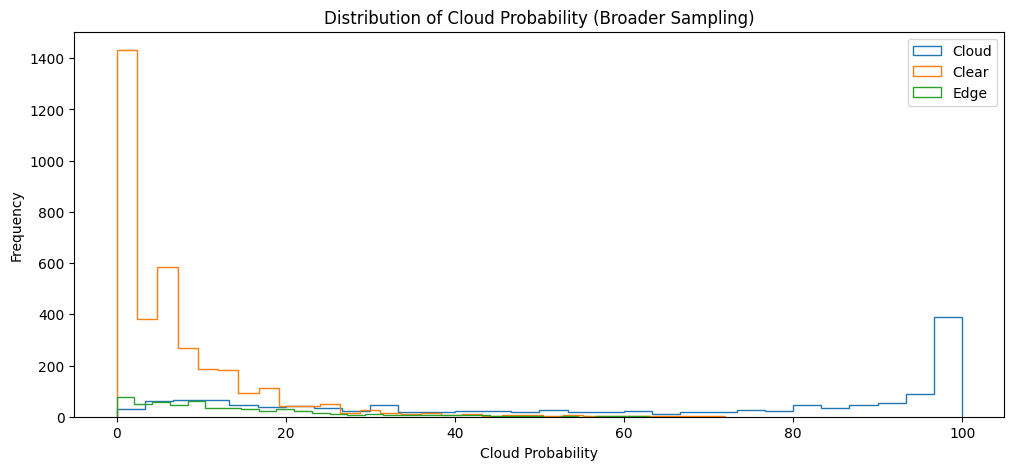

Training K-Means model in Python...
Extracted Cluster Centers:
 [[ 168.54229323  121.6212406   285.4924812    24.97180451]
 [1652.85755814  956.26395349 3067.90930233   39.64534884]]
Cloud cluster ID is: 0
Applying trained model to the full image in Earth Engine...


In [ ]:
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))


def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))


def add_shadow_bands(img, shad_dist):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    # A classic characteristic of shadows is that the are very dark in the NIR band, here B8
    # By multiplying by not_water, pixels are only marked as potential shadows if they are
    # both dark in the NIR (which water is as well) and it is not water
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    # UTM projection: Universal Transverse Mercator projection (Different from the Mercator projection which distorts the sizes of specificlly Greenland and Africa).
    # -> a system for specifying locations on Earth using a grid-based coordinate system.
    # It divides the world into 60 zones, each 6 degrees of longitude wide,
    # and uses a Transverse Mercator projection within each zone to minimize distortion.
    # It takes the information from the image's metadata
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, shad_dist*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))



def add_cld_shdw_mask(img, shad_dist):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud, shad_dist)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches (focalMin(2) removes single dark pixels that make no sense either way) and dilate remaining pixels by BUFFER input (focalMax() to make edges of clouds fuzzier).
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    # This two-step process of erosion then dilation is a standard image processing technique called "morphological opening," which is excellent for noise removal.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)


def apply_cld_shdw_mask(img):
    cloudmask = img.select('cloudmask')
    # Mask cloudy pixels
    masked_img = img.updateMask(cloudmask.Not())
    # Keep cloudmask and probability bands
    cloudmask_band = img.select('cloudmask')
    probability_band = img.select('probability')
    masked_img = masked_img.addBands([cloudmask_band, probability_band], overwrite=True)
    return masked_img



# ====================================================================================
# === PLOTTING AND VISUALIZATION FUNCTIONS START HERE ===
# ====================================================================================

def apply_cloud_only_visualization(ee_image):
    """Visualizes ONLY the 'clouds' band on the true-color image."""
    rgb_vis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000, 'gamma': 1.1}
    background = ee_image.visualize(**rgb_vis)
    cloud_vis = ee_image.select('clouds').selfMask().visualize(**{'palette': ['#e056fd']}) # Purple
    return background.blend(cloud_vis)

def apply_shadow_only_visualization(ee_image):
    """Visualizes ONLY the 'shadows' band on the true-color image."""
    rgb_vis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000, 'gamma': 1.1}
    background = ee_image.visualize(**rgb_vis)
    shadow_vis = ee_image.select('shadows').selfMask().visualize(**{'palette': ['#FFFF00']}) # Yellow
    return background.blend(shadow_vis)

def apply_total_mask_visualization(ee_image):
    """Applies visualization parameters to show the final combined mask over the true-color image."""
    rgb_vis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000, 'gamma': 1.1}
    background = ee_image.visualize(**rgb_vis)
    mask_vis = ee_image.select('cloudmask').selfMask().visualize(**{'palette': ['#FF8C00']}) # Orange
    return background.blend(mask_vis)


def create_comparison_figure(arrays, caption_text, output_filename):
    """Creates and saves a 3x2 comparison figure from image data arrays."""
    fig, axes = plt.subplots(3, 2, figsize=(16, 24))

    # Define titles for each panel
    titles = [
        'Initial Clouds Only', 'Final Clouds Only',
        'Initial Shadows Only', 'Final Shadows Only',
        'Initial Total Mask', 'Final Total Mask'
    ]

    # Flatten the axes array for easy iteration and assign images and titles
    ax_flat = axes.flatten()
    for i, arr in enumerate(arrays):
        ax_flat[i].imshow(arr)
        ax_flat[i].set_title(titles[i], fontsize=14, weight='bold')
        ax_flat[i].axis('off')

    # Add shared elements
    fig.text(0.5, 0.01, caption_text, ha='center', va='bottom', wrap=True, fontsize=13)
    plt.suptitle('Figure 1: Cloud & Shadow Mask Component Comparison', fontsize=18, weight='bold')
    fig.tight_layout(rect=[0, 0.05, 1, 0.96]) # Adjust layout for caption
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Figure saved successfully as '{output_filename}'")

# ====================================================================================
# === SAMPLING FUNCTIONS START HERE ===
# ====================================================================================

def define_cloud_zones(img, edge_buffer=120):
    cloudmask = img.select('cloudmask')

    # Interior cloud pixels: cloudmask==1, away from edges (small erosion)
    cloud_interior = cloudmask.selfMask().focal_min(3)

    # Interior clear pixels: cloudmask==0, away from edges (medium erosion)
    clear_interior = cloudmask.Not().selfMask().focal_min(10)

    # Cloud edge pixels: buffer zone around clouds, but outside cloudmask
    cloud_edge = cloudmask.focal_max(edge_buffer / 10).And(cloudmask.Not())

    return cloud_interior, clear_interior, cloud_edge


def sample_zones(img, region, edge_buffer=20):
    cloudmask = img.select('cloudmask')

    cloud_interior = cloudmask.selfMask()
    clear_interior = cloudmask.Not().selfMask()
    cloud_edge = cloudmask.focal_max(edge_buffer).And(cloudmask.Not())

    sample_bands = ['B2', 'B3', 'B4', 'B5', 'B6' , 'B9', 'B8', 'B11', 'B12']
    if 'probability' in img.bandNames().getInfo():
        sample_bands.append('probability')

    # I added the else statement for debugging reasons
    else:
      print("No probability")

    img_for_sampling = img.select(sample_bands)

    cloud_samples = img_for_sampling.updateMask(cloud_interior).sample(
        region=region, scale=10, numPixels=5000, seed=0, geometries=True)

    clear_samples = img_for_sampling.updateMask(clear_interior).sample(
        region=region, scale=10, numPixels=5000, seed=1, geometries=True)

    edge_samples = img_for_sampling.updateMask(cloud_edge).sample(
        region=region, scale=10, numPixels=5000, seed=2, geometries=True)

    return cloud_samples, clear_samples, edge_samples

# Function to convert a earth engine feature class to a pandas df
def fc_to_df(fc):
    features = fc.getInfo()['features']
    rows = []
    for f in features:
        props = f['properties']
        coords = f['geometry']['coordinates']
        props['longitude'] = coords[0]
        props['latitude'] = coords[1]
        rows.append(props)
    return pd.DataFrame(rows)

# Function to go the other way! This time from a dataframe to the feature collection
def df_to_ee_fc(df):
    features = []
    for _, row in df.iterrows():
        geom = ee.Geometry.Point([row['longitude'], row['latitude']])
        props = {k: float(row[k]) for k in ['B2', 'B8', 'B9', 'B11', 'probability']}
        props['predicted_class'] = row['predicted_class']
        features.append(ee.Feature(geom, props))
    return ee.FeatureCollection(features)

# ====================================================================================
# === EARTH ENGINE CLASSIFICATION FUNCTIONS START HERE ===
# ====================================================================================

# Map predicted class to numeric
def class_to_numeric(feature):
    cls = feature.get('predicted_class')
    return feature.set('cloud_refined', ee.Number(ee.Algorithms.If(ee.String(cls).equals('Cloud'), 1, 0)))

def classify_image_gee(img, centers, cloud_id, bands):
    """
    Classifies an image using a more robust, band-based distance calculation.
    """
    # Select only the bands that the model was trained on.
    input_img = img.select(bands)

    # --- Calculate distance to the first cluster center (e.g., 'clear') ---
    # Create an image where every pixel has the value of the first center's coordinates.
    center1_img = ee.Image.constant(centers[0])
    # Calculate squared difference for each band and sum them to get total squared distance.
    sq_dist_to_c0 = input_img.subtract(center1_img).pow(2).reduce(ee.Reducer.sum())

    # --- Calculate distance to the second cluster center (e.g., 'cloud') ---
    center2_img = ee.Image.constant(centers[1])
    sq_dist_to_c1 = input_img.subtract(center2_img).pow(2).reduce(ee.Reducer.sum())

    # --- Assign cluster ID based on the shorter distance ---
    # Create an image that is 1 where dist to C1 is less than dist to C0, and 0 otherwise.
    closest_cluster = sq_dist_to_c1.lt(sq_dist_to_c0).rename('cluster')

    # Return a binary image: 1 if the pixel belongs to the cloud cluster, 0 otherwise.
    # Note: We need to check if your cloud_id corresponds to cluster 0 or 1.
    # This logic assumes cluster 0 = clear, cluster 1 = cloud.
    # If cloud_cluster_id is 0, we'd use .Not() or change the logic.
    if cloud_id == 1:
        return closest_cluster
    else: # if cloud_id is 0
        return closest_cluster.Not()

# ====================================================================================
# === MAIN EXECUTION BLOCK ===
# ====================================================================================
if __name__ == '__main__':
    # --- 1. Define Parameters and Region ---
    AOI = ee.Geometry.Point(174.7633, -36.8485)
    START_DATE = '2023-01-01'
    END_DATE = '2023-03-31'
    CLOUD_FILTER = 60
    CLD_PRB_THRESH = 40
    NIR_DRK_THRESH = 0.12
    CLD_PRJ_DIST = 2
    BUFFER = 60

    # A larger bounding box to ensure all our regions are covered for broader sampling
    study_area = ee.Geometry.Rectangle([174.4, -37.1, 175.1, -36.7])

    # Re-collect the S2 as we have changed our filtering params
    s2_sr_cld_col = get_s2_sr_cld_col(study_area, START_DATE, END_DATE)




    collection_size = s2_sr_cld_col.size().getInfo()
    print(f"✅ --- Found {collection_size} images in the initial collection. ---")

    # If the collection is empty, the script cannot proceed.
    if collection_size == 0:
        raise ValueError("❌ ERROR: No images found for the selected date/region. Please adjust your parameters.")






    # Re-run s2cloudless approach, this time with .moasic as the compositing operator
    s2_sr_mosaic = (s2_sr_cld_col.map(lambda img: add_cld_shdw_mask(img, CLD_PRJ_DIST))
                           .map(apply_cld_shdw_mask)
                           .mosaic())



    try:
    # Get the list of band names from the final mosaic
      mosaic_bands = s2_sr_mosaic.bandNames().getInfo()
      print(f"✅ --- Mosaic created successfully with bands: {mosaic_bands} ---")

      if not mosaic_bands:
          raise ValueError("❌ ERROR: The mosaic was created but has NO BANDS. This is likely because cloud masking removed all pixels.")

    except Exception as e:
        print("❌ ERROR: Failed to get info from the mosaic. This confirms the mosaic object is invalid.")
        raise e

    # --- K-Means Clustering with improved sampling ---
    # Use the broader study_area for sampling
    cloud_samples, clear_samples, edge_samples = sample_zones(s2_sr_mosaic, study_area)
    cloud_df = fc_to_df(cloud_samples)
    clear_df = fc_to_df(clear_samples)
    edge_df = fc_to_df(edge_samples)

    print(f"Cloud samples: {len(cloud_df)}")
    print(f"Clear samples: {len(clear_df)}")
    print(f"Edge samples: {len(edge_df)}")
    print("Cloud columns:", cloud_df.columns)

    # Histogram of cloud probability by class
    plt.figure(figsize=(12, 5))
    plt.hist(cloud_df['probability'], bins=30, histtype='step', label='Cloud')
    plt.hist(clear_df['probability'], bins=30, histtype='step', label='Clear')
    plt.hist(edge_df['probability'], bins=30, histtype='step', label='Edge')
    plt.xlabel('Cloud Probability')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Distribution of Cloud Probability (Broader Sampling)')
    plt.show()

    # --- Prepare data for K-Means ---
    cloud_df['class'] = 'Cloud'
    clear_df['class'] = 'Clear'
    combined_df = pd.concat([cloud_df, clear_df])
    min_count = combined_df['class'].value_counts().min()
    balanced_df = combined_df.groupby('class').sample(n=min_count, random_state=42)

    # Features to use for clustering (Based on previous analysis, probability and SWIR bands are good)
    features = ['B11', 'B12', 'B8', 'probability'] # Example features, adjust based on Q5

    X_train = balanced_df[features].values
    y_train = (balanced_df['class'] == 'Cloud').astype(int).values

    print("Training K-Means model in Python...")
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10).fit(X_train)

    # Extract Cluster Centers from Python ---
    cluster_centers = kmeans.cluster_centers_
    print("Extracted Cluster Centers:\n", cluster_centers)

    # Map clusters to classes (0 or 1)
    labels, counts = np.unique(kmeans.labels_[y_train==0], return_counts=True)
    clear_cluster_id = labels[np.argmax(counts)]
    cloud_cluster_id = 1 - clear_cluster_id # Assumes only two clusters
    print(f"Cloud cluster ID is: {cloud_cluster_id}")

    # --- Apply trained model to the full image in Earth Engine ---
    print("Applying trained model to the full image in Earth Engine...")

In [ ]:
_, _, edge_zone = define_cloud_zones(s2_sr_mosaic)
edge_zone = edge_zone.clip(study_area) # Clip to the study area

# Classify the entire mosaic
classified_image = classify_image_gee(s2_sr_mosaic, cluster_centers.tolist(), cloud_cluster_id, features)

try:
    print("✅ --- Verifying classified_image ---")
    print(classified_image.getInfo())
    print("------------------------------------")
except Exception as e:
    print("❌ ERROR: The 'classify_image_gee' function produced an invalid object.")
    print(e)
    # Stop here if it fails

# Apply the classification ONLY to the edge pixels
refined_edge_mask = classified_image.updateMask(edge_zone).rename('refined_edge_mask')
# Cast the float mask to an 8-bit integer to ensure data types match
refined_edge_mask = refined_edge_mask.toUint8()

# Combine the original mask with the newly classified edge pixels
original_cloudmask = s2_sr_mosaic.select('cloudmask').unmask(0)
final_refined_mask = original_cloudmask.Or(refined_edge_mask).rename('cloudmask_refined')

# --- Visualize results ---
# Figure 1: Show impact of broader sampling (using the histogram generated above)
# Figure 2: Show the final refined cloud mask

# Display the original and refined cloud masks on a map (Figure 2 equivalent)
Map = geemap.Map()
Map.centerObject(study_area, 10) # Center on the larger study area

# Add the S2 mosaic for context
s2_vis_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 2500,
    'gamma': 1.1
}

# 2. Add the original image (s2_sr_mosaic) to the map with its visualization parameters.
Map.addLayer(s2_sr_mosaic, s2_vis_params, 'S2 Mosaic (Context)')

# Show original cloudmask
Map.addLayer(original_cloudmask.selfMask(), {'palette': ['red']}, 'Original cloudmask')

# Show refined edge mask (the new pixels classified by K-Means)
Map.addLayer(refined_edge_mask.selfMask(), {'palette': ['blue']}, 'K-Means refined edge mask')

# Show the final combined mask (optional, but good for comparison)
Map.addLayer(final_refined_mask.selfMask(), {'palette': ['orange']}, 'Final Refined cloudmask')

print("Displaying results on geemap.")
Map

✅ --- Verifying classified_image ---
{'type': 'Image', 'bands': [{'id': 'cluster', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 1}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}
------------------------------------
Displaying results on geemap.


Map(center=[-36.90033855195713, 174.75000000000009], controls=(WidgetControl(options=['position', 'transparent…

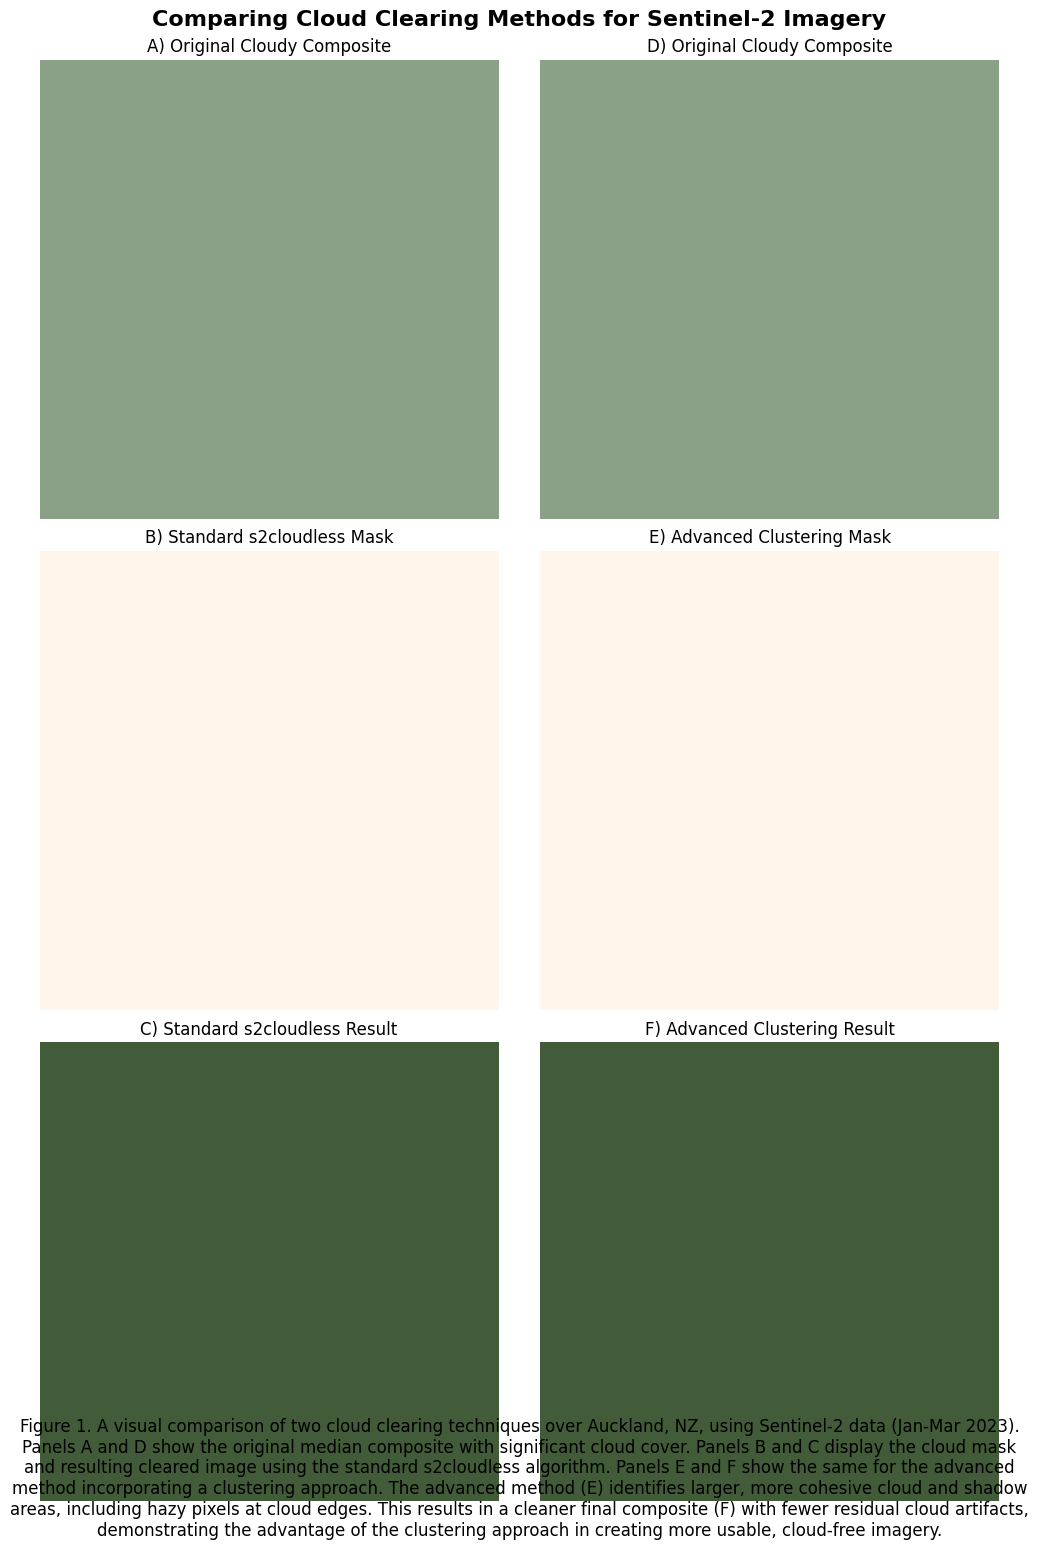

In [ ]:
import matplotlib.pyplot as plt
import geemap
import numpy as np
import ee

# --- Data Preparation (Same as before) ---

# Assuming 's2_sr_cld_col_eval', 'add_cld_shdw_mask', 'AOI', etc.
# are all defined as they were in your notebook.

def add_cld_shdw_mask_s2cloudless(img):
    BUFFER_STANDARD = 10
    img_cloud = add_cloud_bands(img)
    img_cloud_shadow = add_shadow_bands(img_cloud, CLD_PRJ_DIST_1)
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER_STANDARD * 2 / 20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))
    return img.addBands(is_cld_shdw)

s2_sr_cld_col_eval_adv = s2_sr_cld_col_eval.map(
    lambda img: add_cld_shdw_mask(img, CLD_PRJ_DIST_2)
)
s2_sr_cld_col_eval_std = s2_sr_cld_col_eval.map(add_cld_shdw_mask_s2cloudless)

cloud_free_composite_std = s2_sr_cld_col_eval_std.map(
    lambda img: img.updateMask(img.select('cloudmask').Not())
).median()
cloud_free_composite_adv = s2_sr_cld_col_eval_adv.map(
    lambda img: img.updateMask(img.select('cloudmask').Not())
).median()

# --- NEW: Helper function to scale data for plotting ---
def scale_for_display(img_array, max_val=2500, gamma=1.1):
    """Scales a NumPy array from Earth Engine to be displayed."""
    # Handle potential empty arrays
    if img_array is None or img_array.size == 0:
        return np.zeros((10, 10, 3), dtype=np.uint8) # Return a black square if empty

    # Scale to 0-1 range
    scaled_img = img_array / max_val
    # Apply gamma correction
    gamma_corrected_img = np.power(scaled_img, 1/gamma)
    # Clip to ensure values are within [0, 1] for imshow
    return np.clip(gamma_corrected_img, 0, 1)


# --- Get Images for Plotting (Revised Method) ---
rgb_bands = ['B4', 'B3', 'B2']
region = AOI.buffer(2500).bounds()

# Download the raw band data directly
original_image = geemap.ee_to_numpy(s2_sr_cld_col_eval.select(rgb_bands).median(), region=region)
mask_std = geemap.ee_to_numpy(s2_sr_cld_col_eval_std.mosaic().select('cloudmask'), region=region)
cleared_std = geemap.ee_to_numpy(cloud_free_composite_std.select(rgb_bands), region=region)
mask_adv = geemap.ee_to_numpy(s2_sr_cld_col_eval_adv.mosaic().select('cloudmask'), region=region)
cleared_adv = geemap.ee_to_numpy(cloud_free_composite_adv.select(rgb_bands), region=region)


# --- Create the Visualization ---
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
fig.suptitle('Comparing Cloud Clearing Methods for Sentinel-2 Imagery', fontsize=16, weight='bold')

# --- Column 1: Standard Method ---
axes[0, 0].imshow(scale_for_display(original_image))
axes[0, 0].set_title('A) Original Cloudy Composite', fontsize=12)
axes[0, 0].axis('off')

axes[1, 0].imshow(mask_std, cmap='Oranges', vmin=0, vmax=1)
axes[1, 0].set_title('B) Standard s2cloudless Mask', fontsize=12)
axes[1, 0].axis('off')

axes[2, 0].imshow(scale_for_display(cleared_std))
axes[2, 0].set_title('C) Standard s2cloudless Result', fontsize=12)
axes[2, 0].axis('off')

# --- Column 2: Advanced Method ---
axes[0, 1].imshow(scale_for_display(original_image))
axes[0, 1].set_title('D) Original Cloudy Composite', fontsize=12)
axes[0, 1].axis('off')

axes[1, 1].imshow(mask_adv, cmap='Oranges', vmin=0, vmax=1)
axes[1, 1].set_title('E) Advanced Clustering Mask', fontsize=12)
axes[1, 1].axis('off')

axes[2, 1].imshow(scale_for_display(cleared_adv))
axes[2, 1].set_title('F) Advanced Clustering Result', fontsize=12)
axes[2, 1].axis('off')

# --- Caption ---
caption = (
    "Figure 1. A visual comparison of two cloud clearing techniques over Auckland, NZ, using Sentinel-2 data (Jan-Mar 2023).\n"
    "Panels A and D show the original median composite with significant cloud cover. Panels B and C display the cloud mask\n"
    "and resulting cleared image using the standard s2cloudless algorithm. Panels E and F show the same for the advanced\n"
    "method incorporating a clustering approach. The advanced method (E) identifies larger, more cohesive cloud and shadow\n"
    "areas, including hazy pixels at cloud edges. This results in a cleaner final composite (F) with fewer residual cloud artifacts,\n"
    "demonstrating the advantage of the clustering approach in creating more usable, cloud-free imagery."
)
fig.text(0.5, -0.02, caption, ha='center', fontsize=12)

plt.show()